## Предсказать price - цену автомобиля на основе его характеристик

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from functools import partial

In [2]:
df = pd.read_csv('Cars_Price.csv')
df

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


In [3]:
# проверим дублирование
df.duplicated().sum()

0

In [4]:
# посмотрим количество пропусков, тип в каждом из столбцов
print(df.info())

# в данном датасете нет null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [5]:
df = df.drop(columns=['car_ID'])

In [6]:
df.nunique()

symboling             6
CarName             147
fueltype              2
aspiration            2
doornumber            2
carbody               5
drivewheel            3
enginelocation        2
wheelbase            53
carlength            75
carwidth             44
carheight            49
curbweight          171
enginetype            7
cylindernumber        7
enginesize           44
fuelsystem            8
boreratio            38
stroke               37
compressionratio     32
horsepower           59
peakrpm              23
citympg              29
highwaympg           30
price               189
dtype: int64

In [7]:
df.describe()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [8]:
# Посмотрим что у нас в катеориальных признках
categorical_columns = ['fueltype','aspiration','doornumber','carbody','drivewheel','enginelocation','enginetype',
    'cylindernumber',
    'fuelsystem'
]

for col in categorical_columns:

    print(f"Category in {col} is : {df[col].unique()}")

Category in fueltype is : ['gas' 'diesel']
Category in aspiration is : ['std' 'turbo']
Category in doornumber is : ['two' 'four']
Category in carbody is : ['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
Category in drivewheel is : ['rwd' 'fwd' '4wd']
Category in enginelocation is : ['front' 'rear']
Category in enginetype is : ['dohc' 'ohcv' 'ohc' 'l' 'rotor' 'ohcf' 'dohcv']
Category in cylindernumber is : ['four' 'six' 'five' 'three' 'twelve' 'two' 'eight']
Category in fuelsystem is : ['mpfi' '2bbl' 'mfi' '1bbl' 'spfi' '4bbl' 'idi' 'spdi']


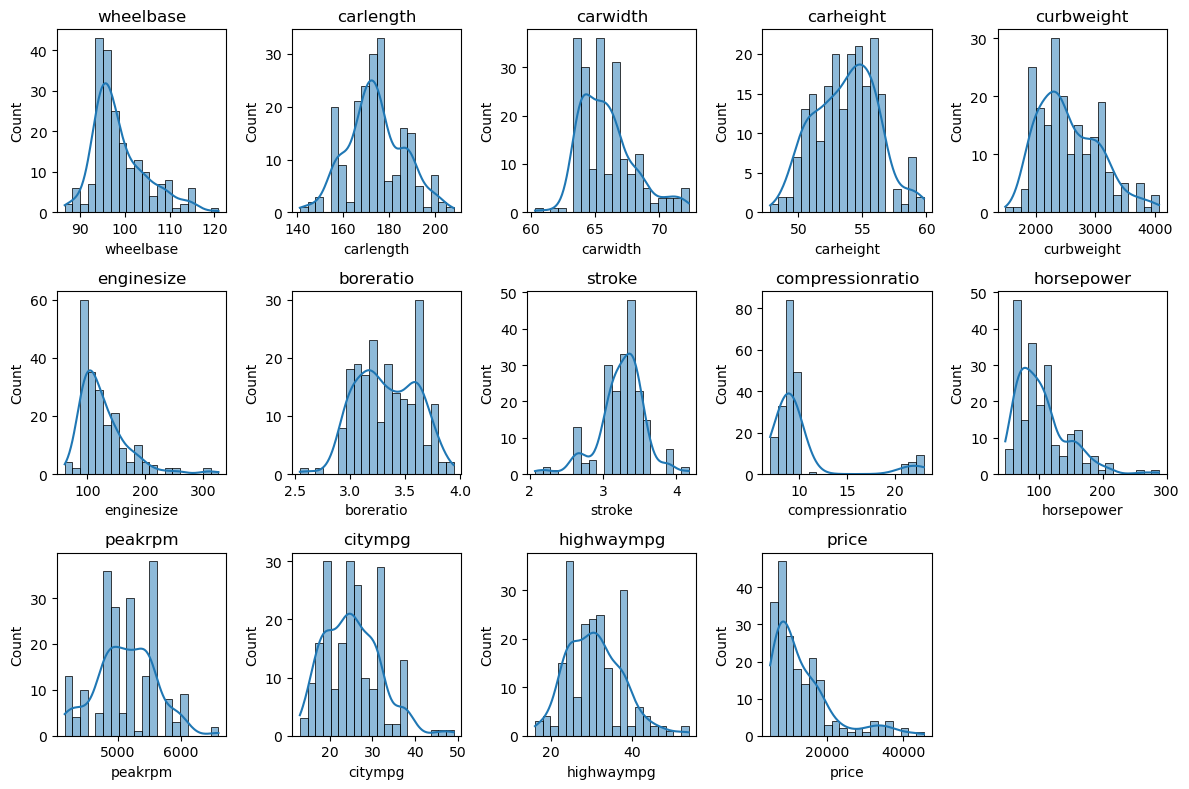

In [10]:
# Рассмотрим распредлеение численных признаков
numerical_features = ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
                      'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
                      'peakrpm', 'citympg', 'highwaympg', 'price']

plt.figure(figsize=(12, 8))
for feature in numerical_features:
    plt.subplot(3, 5, numerical_features.index(feature) + 1)
    sns.histplot(data=df[feature], bins=20, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

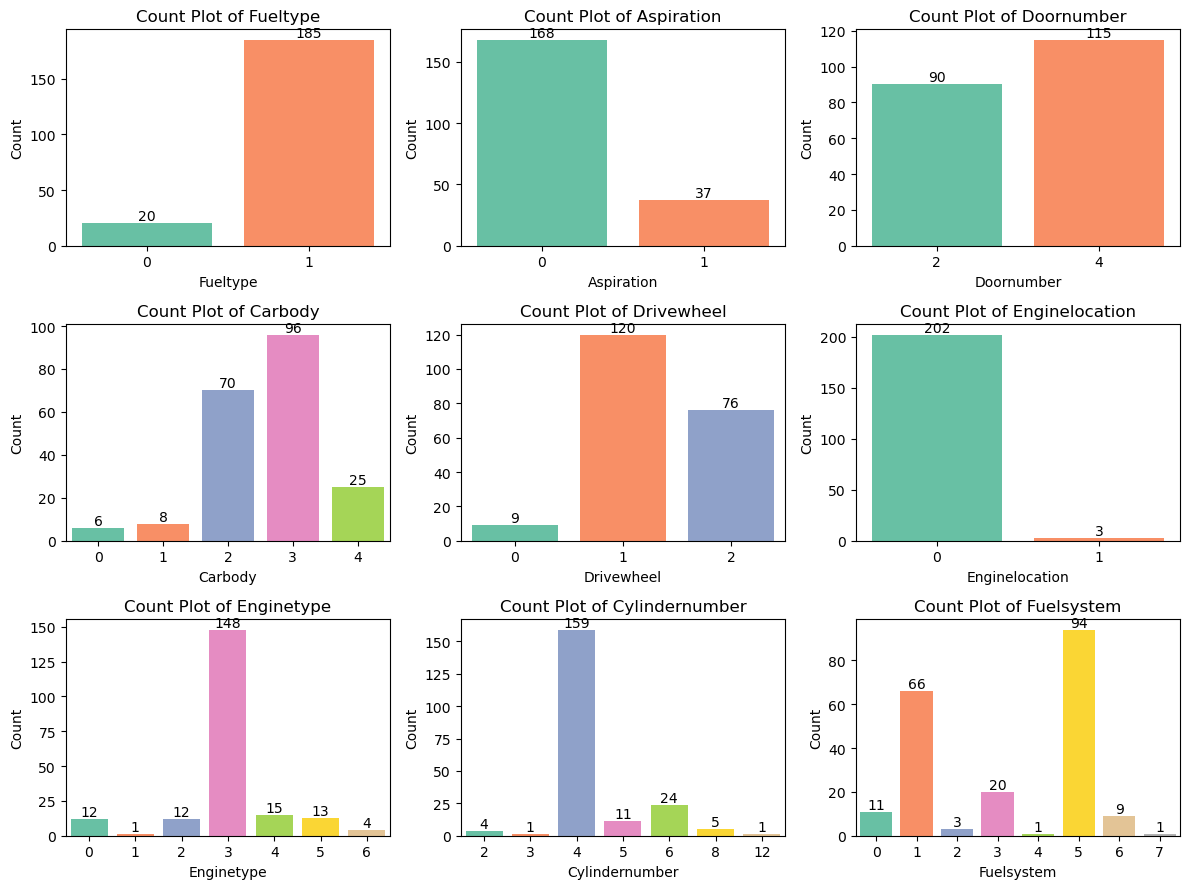

In [52]:
# Рассмотрим распредлеение категориальных признаков
categorical_columns = ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel',
                       'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem']

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))
axes = axes.ravel()  # Flatten the 2D array of axes

# Loop through each categorical column
for i, column in enumerate(categorical_columns):
    sns.countplot(x=df[column], data=df, palette='Set2', ax=axes[i], saturation=0.95)
    for container in axes[i].containers:
        axes[i].bar_label(container, color='black', size=10)
    axes[i].set_title(f'Count Plot of {column.capitalize()}')
    axes[i].set_xlabel(column.capitalize())
    axes[i].set_ylabel('Count')

# Adjust layout and show plots
plt.tight_layout()
plt.show()

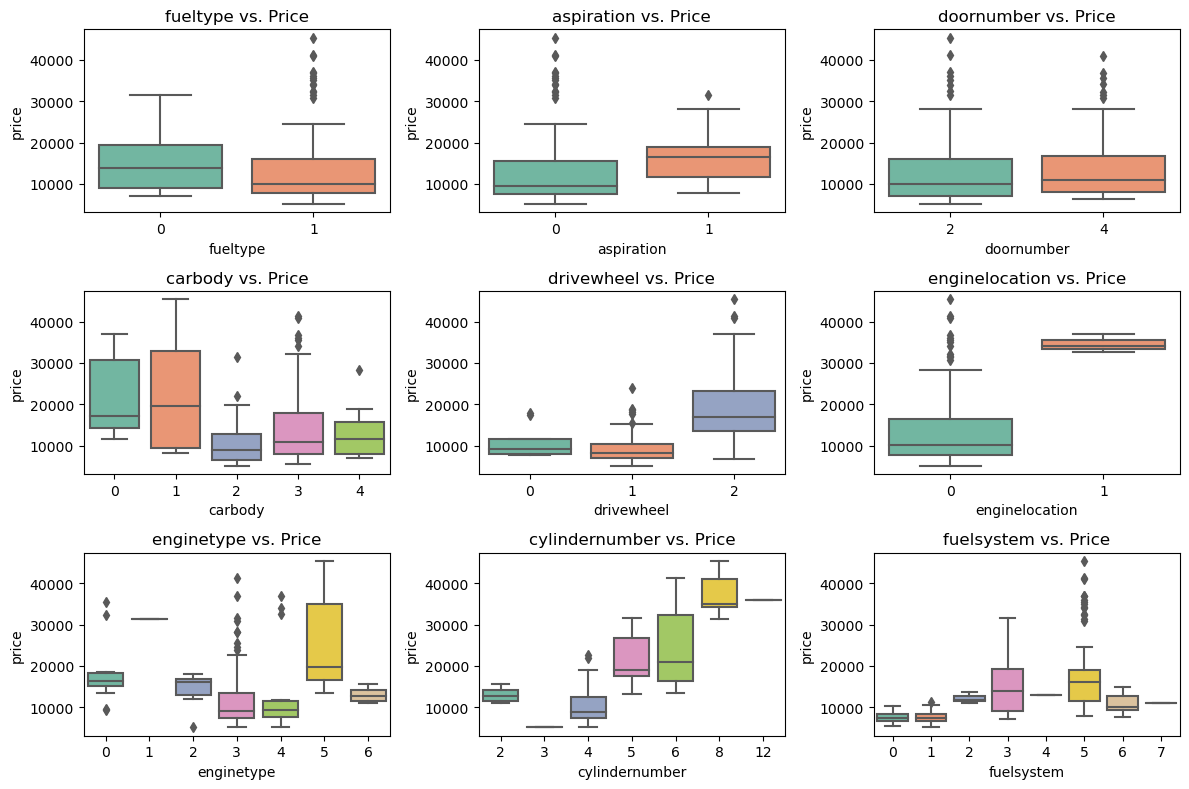

In [53]:
# Категориальные признаки vs price
plt.figure(figsize=(12, 8))
for feature in categorical_columns:
    plt.subplot(3, 3, categorical_columns.index(feature) + 1)
    sns.boxplot(data=df, x=feature, y='price', palette='Set2')  # Указываем палитру
    plt.title(f'{feature} vs. Price')
plt.tight_layout()
plt.show()


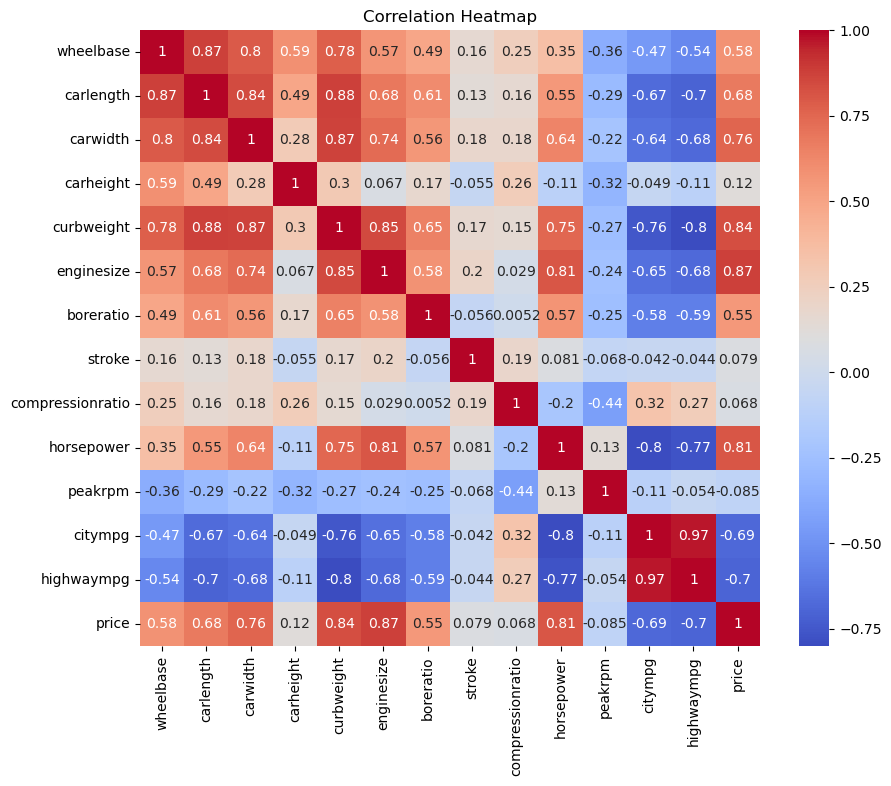

In [12]:
# матрицa корреляций
correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Заметим, что у нам много высоко коррелированных признаков
# citympg и highwaympg
# wheelbase, carlength, сarwidth, curbweight
# enginesize, horsepower, сarwidth, curbweight, price

In [13]:
# Будем рабоать с копией

def daily_summary_parse(df: pd.DataFrame) -> pd.DataFrame:

    contains = lambda data, name, num: data[name].str.contains(num).astype(int)

    df = df.copy()

    return df

df = daily_summary_parse(df)

In [14]:
# удаление высоко скорелированных между собой признаков и создание новых
'''
citympg и highwaympg - расход топлива в гроде и вне города. Удалим highwaympg - так как имеет меньшую корреляцию с таргетом
Оба признака очень близки по смыслу дргу к другу. Они нам не нужны оба. Можно конечно брать среднее значение и получить средний расход.
Возьмем средний расход вместо этих двух.
'''

df['average_mpg'] = (df['citympg'] + df['highwaympg']) / 2

'''
Создадим новые признаки, которые объединяют в себе высоко коррелированные признаки
'''

# Создание нового признака для размера: (ширина * длина) / вес
df['size_ratio'] = (df['carwidth'] * df['carlength']) / df['curbweight']

# Создание индекса мощности: engine_power_index = enginesize * horsepower / curbweight
df['engine_power_index'] = (df['enginesize'] * df['horsepower']) / df['curbweight']

df = df.drop(columns=['carwidth', 'carlength', 'curbweight', 'enginesize', 'horsepower', 'citympg', 'highwaympg'], errors='ignore')

'''
Теперь высокая корреляция у следующих признаков:
price, engine_power_index - нам важны оба признака. Один из них - целевой, а второй вероятно важен для распределения цен
size_ratio, average_mpg - тут можно оставить один из них или создать новый
'''

# Создание новых признаков:

# Создаем новый признак efficiency_index
df['efficiency_index'] = df['size_ratio'] / df['average_mpg']

# Удаляем исходные признаки, если они больше не нужны
df = df.drop(columns=['size_ratio', 'average_mpg'], errors='ignore')


In [15]:
# заметим, что количеств дверей - категориальный признак, котрый можно представить численным
df['doornumber'] = df['doornumber'].replace({'two': 2, 'four': 4})
df['cylindernumber'] = df['cylindernumber'].replace({
    'four': 4,
    'six': 6,
    'five': 5,
    'eight': 8,
    'twelve': 12,
    'three': 3,
    'two': 2
})

# название машины разделим на марку и название модели
df[['brand', 'model']] = df['CarName'].str.split(' ', n=1, expand=True)
df = df.drop(columns=['CarName'])



# для категориальных признаков, у которых мало значений применим:
# encoder = OneHotEncoder(handle_unknown='ignore')
# encoded_array = encoder.fit_transform(df[['fueltype']])
# encoder_df = pd.DataFrame(encoded_array.toarray(), columns=encoder.get_feature_names_out(['fueltype']))
# df = df.join(encoder_df, rsuffix='_encoder')

# encoded_array = encoder.fit_transform(df[['aspiration']])
# encoder_df = pd.DataFrame(encoded_array.toarray(), columns=encoder.get_feature_names_out(['aspiration']))
# df = df.join(encoder_df, rsuffix='_encoder')

# encoded_array = encoder.fit_transform(df[['enginelocation']])
# encoder_df = pd.DataFrame(encoded_array.toarray(), columns=encoder.get_feature_names_out(['enginelocation']))
# df = df.join(encoder_df, rsuffix='_encoder')

# encoded_array = encoder.fit_transform(df[['drivewheel']])
# encoder_df = pd.DataFrame(encoded_array.toarray(), columns=encoder.get_feature_names_out(['drivewheel']))
# df = df.join(encoder_df, rsuffix='_encoder')

# labelencoder = LabelEncoder()
# df['cylindernumber'] = LabelEncoder().fit_transform(df['cylindernumber'])

In [16]:
# Define categorical and numerical columns
categorical_columns = ['fueltype', 'aspiration', 'carbody', 'drivewheel',
                       'enginelocation', 'enginetype', 'fuelsystem', 'brand', 'model']
numerical_columns = ['wheelbase', 'boreratio', 'stroke', 'compressionratio', 'peakrpm', 'engine_power_index', 'efficiency_index']

# Encoding categorical variables
label_encoder = LabelEncoder()
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

# Feature scaling
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [17]:
# видоизменение и удаление признаков, для упрощения работы

df

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carheight,enginetype,...,fuelsystem,boreratio,stroke,compressionratio,peakrpm,price,engine_power_index,efficiency_index,brand,model
0,3,1,0,2,0,2,0,-1.690772,48.8,0,...,5,0.519071,-1.839377,-0.288349,-0.262960,13495.0,0.130457,0.261938,1,78
1,3,1,0,2,0,2,0,-1.690772,48.8,0,...,5,0.519071,-1.839377,-0.288349,-0.262960,16500.0,0.130457,0.261938,1,122
2,1,1,0,2,2,2,0,-0.708596,52.4,5,...,5,-2.404880,0.685946,-0.288349,-0.262960,16500.0,1.038167,0.247381,1,28
3,2,1,0,4,3,1,0,0.173698,54.3,3,...,5,-0.517266,0.462183,-0.035973,0.787855,13950.0,-0.182361,0.570139,2,0
4,2,1,0,4,3,0,0,0.107110,54.3,3,...,5,-0.517266,0.462183,-0.540725,0.787855,17450.0,0.087285,1.395499,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,1,0,4,3,2,0,1.721873,55.5,3,...,5,1.666445,-0.336970,-0.162161,0.577692,16845.0,0.055128,0.109375,26,5
201,-1,1,1,4,3,2,0,1.721873,55.5,3,...,5,1.666445,-0.336970,-0.364062,0.367529,19045.0,0.729888,0.879310,26,4
202,-1,1,0,4,3,2,0,1.721873,55.5,5,...,5,0.926204,-1.232021,-0.338824,0.787855,21485.0,0.832585,1.508454,26,6
203,-1,0,1,4,3,2,0,1.721873,55.5,3,...,3,-1.183483,0.462183,3.244916,-0.683286,22470.0,-0.175329,-0.637670,26,8


In [18]:
# Splitting the dataset
X = df.drop(['price'], axis=1)  # Include the engineered features and CarName
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [19]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2_square = r2_score(y_test,y_pred)
print(f" R-squared: {r2_square}")
print(f'Mean Squared Error: {mse}')

 R-squared: 0.8273867292570913
Mean Squared Error: 13626785.64963418


In [20]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
15,30760.000,27891.744872,2868.255128
9,17859.167,16045.099934,1814.067066
100,9549.000,10206.236164,-657.236164
132,11850.000,14133.877686,-2283.877686
68,28248.000,22088.310240,6159.689760
95,7799.000,7034.552002,764.447998
159,7788.000,8583.729281,-795.729281
162,9258.000,6186.800529,3071.199471
147,10198.000,9384.586003,813.413997
182,7775.000,7103.305413,671.694587


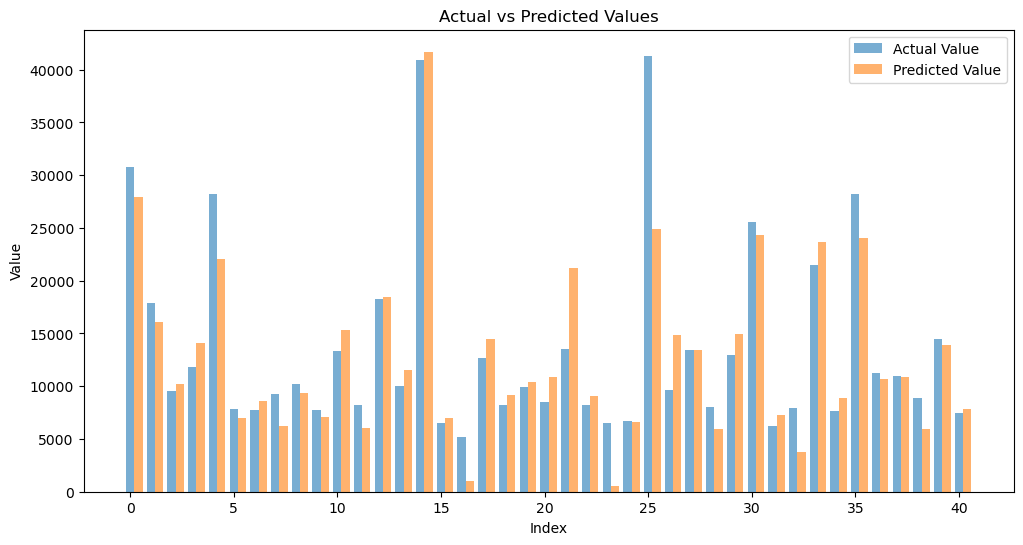

In [ ]:
# визуализация
x = np.arange(len(y_test))
plt.figure(figsize=(12, 6))

plt.bar(x, y_test, width=0.4, label='Actual Value', alpha=0.6)
plt.bar(x + 0.4, y_pred, width=0.4, label='Predicted Value', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


